In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import multiprocessing
import os
import numpy as np
import cv2
import shutil
from google.colab.patches import cv2_imshow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Train directory
os.chdir("/content/drive/My Drive/Colab Notebooks/train")
train_directory = ("/content/drive/My Drive/Colab Notebooks/train")

# New directory
new_directory = "/content/drive/My Drive/Colab Notebooks/new"

# Free if exists
if os.path.isdir(new_directory):
  shutil.rmtree(new_directory)

# Create directory and change to
os.mkdir(new_directory)
os.chdir(new_directory)

print("Текущая деректория:", os.getcwd())

n = int(input("Enter n - image size: "))
make_white_background = True

Текущая деректория: /content/drive/My Drive/Colab Notebooks/new
Enter n - image size: 128


In [ ]:
def get_up(threshed):
  color = threshed[0][0]
  for i in range(len(threshed)):
    for j in range(len(threshed[0])):      
      if (np.sum(threshed[i][j]) != color):
        return i

def get_down(threshed):
  color = threshed[0][0]
  for i in reversed(range(len(threshed))):
    for j in range(len(threshed[0])):  
      if (np.sum(threshed[i][j]) != color):
        return i

def get_left(threshed):
  color = threshed[0][0]
  for i in range(len(threshed[0])):
    for j in range(len(threshed)):  
      if (np.sum(threshed[j][i]) != color):
        return i

def get_right(threshed):
  color = threshed[0][0]
  for i in reversed(range(len(threshed[0]))):
    for j in range(len(threshed)):  
      if (np.sum(threshed[j][i]) != color):
        return i

In [ ]:
def create_image(images_path, path_to_save):
  for image_path in os.listdir(images_path):
    full_path = images_path + "/" + image_path
    image = cv2.imread(full_path)

    if image is None:
      return
    # Monochrome
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    et,threshed = cv2.threshold(gray,0, 255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Crop
    cropped = threshed[get_up(threshed):get_down(threshed), get_left(threshed):get_right(threshed)]

    # Resize
    d = max (len(cropped), len(cropped[0]))
    prop = (n/d);
    resized = cv2.resize(cropped, (int(len(cropped[0]) * prop),int(len(cropped) * prop)))

    # Make Borders
    w,h = resized.shape
    color = int(threshed[0][0])
    img = cv2.copyMakeBorder(resized, int((n-w)/2), int((n-w)/2), int((n-h)/2), int((n-h)/2), cv2.BORDER_CONSTANT, value=(color,color,color))

    # Make White Background
    if (make_white_background):
      white_count = 0
      black_count = 0
      for i in range(len(img)):
        for j in range(len(img[i])):
          if (img[i][j] == 255):
            white_count += 1
          else:
            black_count += 1

      if black_count > white_count:
        img = cv2.bitwise_not(img)

    # Save File
    lock.acquire()
    file_count = len(os.listdir(path_to_save))
    cv2.imwrite(path_to_save + str(file_count) + ".png", img)
    lock.release()

In [ ]:
# Main Cycle
procs = []
lock = multiprocessing.Lock()
for i in os.listdir(train_directory):
    for j in os.listdir(train_directory + "/" + i):
        if j not in os.listdir(new_directory):
          os.mkdir(new_directory + "/" + j)
        images_path = train_directory + "/" + i + "/" + j
        path_to_save = new_directory + "/" + j + "/"
        p = multiprocessing.Process(target=create_image, args=(images_path, path_to_save, ))
        p.start()

[proc.join() for proc in procs]

[]

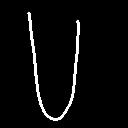

In [ ]:
# Далее идет код для проверок
example = "/content/drive/My Drive/Colab Notebooks/train/2A826C70-7507-41BA-8622-F3034B00547B/U/02.png"
image = cv2.imread(example)
cv2_imshow(image)

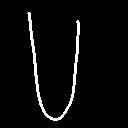

(0, 0, 0)
(255, 255, 255)


In [ ]:
# Monochrome
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
et,threshed = cv2.threshold(gray,0, 255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2_imshow(threshed)
color = threshed[0][0]
print((color,color,color))
print((255,255,255))

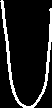

In [ ]:
# Cropped

cropped = threshed[get_up(threshed):get_down(threshed), get_left(threshed):get_right(threshed)]
cv2_imshow(cropped)

1.1851851851851851


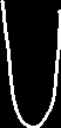

In [ ]:
# Resize
d = max (len(cropped), len(cropped[0]))
prop = (n/d);
print(prop)
resized = cv2.resize(cropped, (int(len(cropped[0]) * prop),int(len(cropped) * prop)))
cv2_imshow(resized)

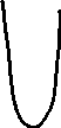

In [ ]:
white_count = 0
black_count = 0
for i in range(len(resized)):
  for j in range(len(resized[i])):
    if (resized[i][j] == 255):
      white_count += 1
    else:
      black_count += 1

if black_count > white_count:
  resized = cv2.bitwise_not(resized)
cv2_imshow(resized)

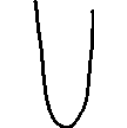

In [ ]:
w,h = resized.shape

img = cv2.copyMakeBorder( resized, int((n-w)/2), int((n-w)/2), int((n-h)/2), int((n-h)/2), cv2.BORDER_CONSTANT, value=(255,255,255))
cv2_imshow(img)

In [ ]:
def create_map(image):
  image_map = pixel_new = [[0.0] * len(image[0]) for i in range(len(image))]
  width = len(image)
  height = len(image[0])
  v1_6 = 1 / 6
  v1_12 = 1 / 12
  for i in range(len(image)):
    for j in range(len(image[0])):
      if (image[i][j] == 255):
        image_map[i][j] = 0.0
      else:
        image_map[i][j] = 1.0
      if (i != 0):
        if (image[i - 1][j] != 255):
          image_map[i][j] += v1_6
        if (j != 0):
          if (image[i - 1][j - 1] != 255):
            image_map[i][j] += v1_12
      if (j != 0):
        if (image[i][j - 1] != 255):
          image_map[i][j] += v1_6
        if (i != width - 1):
          if (image[i + 1][j - 1] != 255):
            image_map[i][j] += v1_12
      if (i != width - 1):
        if (image[i + 1][j] != 255):
          image_map[i][j] += v1_6
        if (j != height - 1):
          if (image[i + 1][j + 1] != 255):
            image_map[i][j] += v1_12
      if (j != height - 1):
        if (image[i][j + 1] != 255):
          image_map[i][j] += v1_6
        if (i != 0):
          if (image[i - 1][j + 1] != 255):
            image_map[i][j] += v1_12
  return image_map

In [ ]:
print(create_map(img))

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.41666666666666663, 1.5, 1.6666666666666667, 1.5, 0.41666666666666663, 0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 1.5, 1.9166666666666667, 2.0, 1.9166666666666667, 1.5, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 